In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
from scipy.stats.stats import pearsonr   
import seaborn as sns
import pandas as pd
sns.set()
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200

In [3]:
def lhs(cons: float, x0: float, gamma: float = 1, r: float = 0) -> float:
    return (gamma * (1+r))*(cons ** 2 / x0) ** 2

def rhs(cons: float, gti: float, ft: float) -> float:
    return 1 - (ft * cons) / (gti - cons)

def bisection(x0: float, gti: float, ft:float, gamma: float, r: float = 0, err: float = 1e-2) -> float:
    # Define the left and right hand sides of the equations
    diff = lambda a: rhs(a, gti, ft) - lhs(a, x0, gamma, r)

    # Initial guess at the next options for
    max_val = gti / (1+ft)
    x = [0, max_val / 2, max_val]
    abs_lst = [abs(diff(i)) for i in x[:2]]

    while min(abs_lst) >= err:
        test = np.sign([diff(i) for i in x])

        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]

        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]

In [4]:
def smoothing(x:float, x0:float, theta:float, xmin:float, xmax:float):
    """ Project the input onto a given scale via tanh """
    return 0.5 * (np.tanh(theta*(x-x0))*(xmax-xmin)+xmax+xmin)

<font size="5">
\begin{align}
H(x, x_0, x_{min}, x_{max}) & = \frac{1}{2}\left(\tanh(\theta(x-x_0))+x_{max}+x_{min}\right)\\
N_t & = c_1 N_{t-1} + c_2 \left(\frac{c_t}{c_{t-1}}-1\right) + c_3 (q_t-r_t) + \xi_t\\
G_t & = H(-N_t, 0, 0.6, 1.0) \\
F_t & = H(N_t, 0, 0.5, 1.5) \\
\end{align}
    
Effectively $G_t$ is kind of like your risk aversion. 
    
If $G_t$ is low, you invest a lot, and are confident to take on the risk of exposure to $z$ on your investments. 
    
If $G_t$ is high, you are keen to preserve your income -> you continue to consume while putting your otherwise risky investments into bonds
    
Using $\frac{c_t}{c_{t-1}}$ in $N$ is good because it is closer to our reality - we observe an obscured signal. By market clearing we can derive that change in consumption is a combination of the technology shock, labour supply and capital supply, which can cancel one another out. E.g. a small negative tech shock can be seen as neutral as long as either labour or capital increase sufficiently (i.e. we produce the same)
\begin{equation}
    \frac{c_t}{c_{t-1}}=\frac{z_t}{z_{t-1}}\left(\frac{n_t}{n_{t-1}}\right)^{1-\alpha}\left(\frac{k_t}{k_{t-1}}\right)^{\alpha}
\end{equation}
</font>

In [13]:
def step(t: float, x: np.ndarray, p: dict):
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, gt_, ft_, news_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
        
    # Income and Investment
    income = w_ * n_ + b_ / (1 + p['inflation']) + q_ * k_ * (1-p['tax'])
    
    # Capital Markets
    k = (1 - p['depreciation']) * k_ + income * (1 - gt_)

    # Household decision
    x0 = z * np.sqrt(2 * k)
    c = bisection(x0, gt_ * income, ft_, p['gamma'], p['interest'])
    n = (c ** 2) / (4 * k * (z ** 2))
    b = (gt_ * income - c) * (1 + p['interest'])
    
    # Firm decisions
    w = 0.5 * c / n
    q = 2 * z * np.sqrt(n/k)

    # Investment rate and savings decision
    xin = np.random.normal(0, p['sigmaN'])
    #print(news_,' ',p['n_persistence'] * news_,' ',(1 - p['n_persistence']) * np.tanh(c/c_ - 1)+ xin)
    new_info = np.tanh(10*(c/c_ - 1)) + np.tanh(p['n_return']*(q - p['interest']))
    news = np.tanh(p['n_cons'] * (p['n_persistence'] * news_ + (1 - p['n_persistence']) * new_info + xin))
    #if t > 440 and t< 600:
    #    news = .7
    gt = smoothing(-news, p['g_0'], p['g_theta'], p['g_min'], p['g_max'])
    ft = smoothing(-news, p['f_0'], p['f_theta'], p['f_min'], p['f_max'])
    #if t > 300 and t < 400:
    #    ft = 1e-5
    
    return z, c, n, b, w, k, q, gt, ft, news, xiz, xin

def simulate(start: np.ndarray, p: dict, t_end: float = 1e3):
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p)
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'gt', 'ft', 'news', 'xiz', 'xin']
    return pd.DataFrame(x, columns=cols)

In [14]:
# SET PARAMETERS
params = dict(
    etaZ=0.2, sigmaZ=.8, zbar=1, sigmaN=.2, #zbar=noE
    inflation=0.01, interest=0.01, depreciation=0.1,
    g_0=0., g_min=0.8, g_max=1.0, g_theta=10,
    f_0=.1, f_min=0., f_max=100, f_theta=10,
    n_persistence=.8, n_cons=1.6, n_return=0,
    gamma=1, tax = 0.
)

# INITIAL VALUES
start = dict(z=1, c=1, n=0, b=1, w=1, k=1, q=0, gt=0.8, ft=.5, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 5e3
np.random.seed(40)

df = simulate(start, params, T)
income = df.w * df.n + df.b/(1+params['inflation']) + params['interest']*df.k
investment = (1 - df.loc[:,'gt']) * income

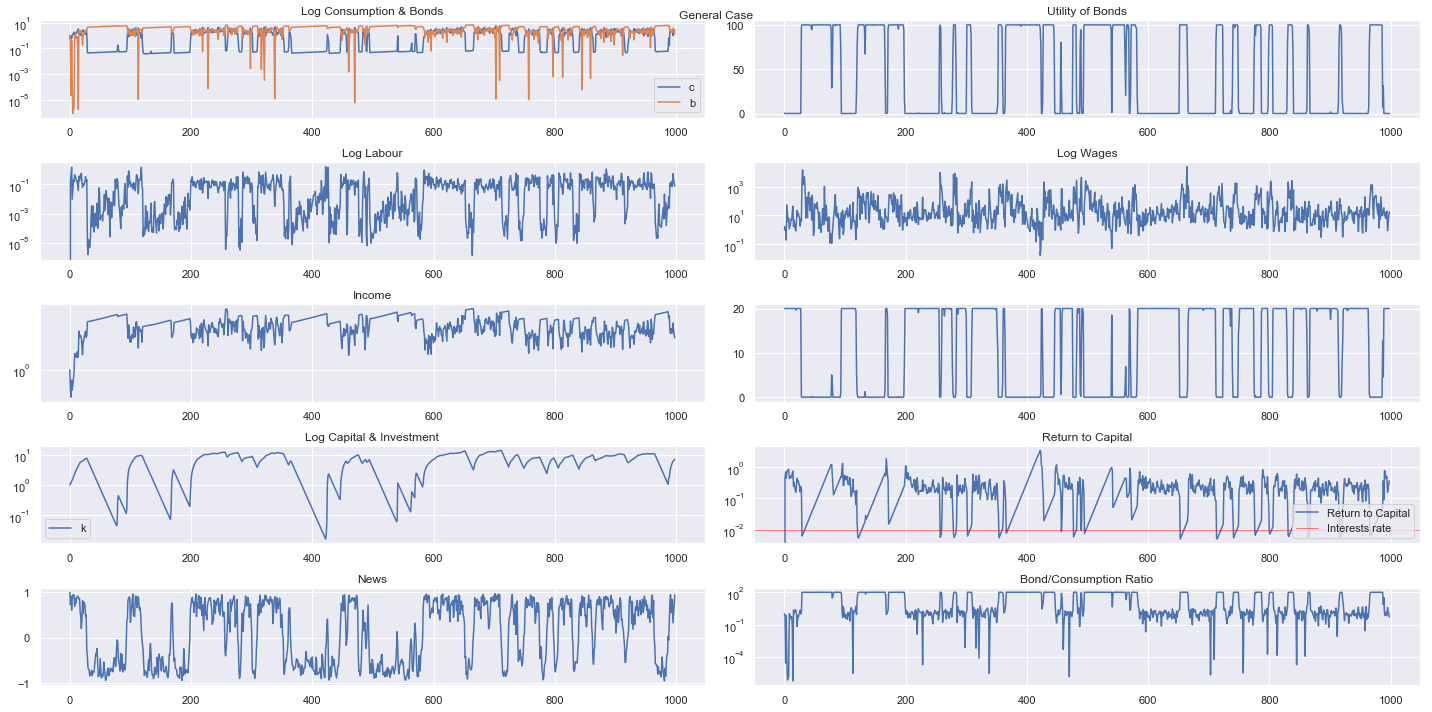

In [15]:
fig, axs= plt.subplots(ncols=2, nrows=5)
fig.suptitle('General Case')
start = 0#2500
stop = int(1e3)-1
# Household
axs[0,0].plot(df.c[start:stop], label='c')
axs[0,0].plot(df.b[start:stop], label='b')
axs[0,0].set_title('Log Consumption & Bonds')
axs[0,0].set_yscale('log')
axs[0,0].legend()

axs[0,1].plot(df.ft[start:stop])
axs[0,1].set_title('Utility of Bonds')

# Labour Market
axs[1,0].plot(df.n[start:stop])
axs[1,0].set_title('Log Labour')
axs[1,0].set_yscale('log')

axs[1,1].plot(df.w[start:stop])
axs[1,1].set_title('Log Wages')
axs[1,1].set_yscale('log')

# Investment Rate
axs[2,0].plot(income[start:stop])
axs[2,0].set_title('Income')
axs[2,0].set_yscale('log')

axs[2,1].plot(100*(1-df.loc[:,'gt'][start:stop]), label = r'Investment [%]')

#axs[2,1].plot()
#axs[2,1].set_title('Investments')

# Capital Market
axs[3,0].plot(df.k[start:stop], label='k')
axs[3,0].set_title('Log Capital & Investment')
axs[3,0].set_yscale('log')
#axs[3,0].plot(investment, color='red', label='inv')
axs[3,0].legend(ncol=2)

axs[3,1].plot(df.q[start:stop], label = 'Return to Capital')
axs[3,1].set_title('Return to Capital')
axs[3,1].axhline(params['interest'], color='red', linewidth=0.5, label='Interests rate')
axs[3,1].legend()
axs[3,1].set_yscale('log')

# News
axs[4,0].plot(df.news[start:stop])
axs[4,0].set_title('News')

axs[4,1].plot(df.b[start:stop]/df.c[start:stop])
axs[4,1].axhline(0, color='red')
axs[4,1].set_yscale('log')
axs[4,1].set_title('Bond/Consumption Ratio')

fig.set_size_inches(20, 10)
fig.tight_layout()
plt.show()

Desired properties
[x] Bi-stable news <br>
[x] Change from investment to the bonds not consumption <br>
[] Labour decreases <br>

Bond dynamics: 
In crisis, we see that the area for the solution becomes smaller i.e. as consumption drops then the remainder is just the bonds. Hence as consumption drops and there is no investment the majority of the income goes to bonds because there isn't anything else to do with it. Feedback on bonds doesn't have much on an effect in this case. 


<font size="5">
    Bonds now increase when consumption decreases, with larger fluctuations included
    Income shows large spiked fluctuations
    We are still missing a nice persistence in the news overall
    Capitalitself is extremely slow-moving, or rather it is very unreactive - as is the investment level itself. Should likely be more volatile. Also in comparison to the labour I would argue that capital should be more volatile than labour?
</font>

In [613]:
g = 4.12691520115423
gamma = 1.0
r = 0.01
x0 = 0.3195333487091828
nx = 10000
x = np.linspace(-5,5,nx)

ut.plot_settings()
fig, ax = plt.subplots(figsize = (6,6))

# AXES
ax.axhline(0, color='k', linewidth=.5)
ax.axvline(0, color='k', linewidth=.5)

# RHS & LHS
ax.plot(x, model.rhs(x, g, gamma, r), color = 'r')
ax.plot(x, model.lhs(x, x0), color = 'b')

# Solution point
cons = model.bisection(x0, g, gamma, r, 1e-4)
g_ = model.rhs(cons, g, gr)

# Key Sections
ax.axvline(g, linestyle='--', color='k')
ax.axvline(g/2, linestyle='--', color='k')
ax.axvline(cons, linewidth=1, color='k')

# Mark the Solution
circle_rad = 3  # This is the radius, in points
ax.plot(cons, g_, 'o', ms=circle_rad * 2, mec='k', mfc='none', mew=1)
ax.annotate('Unique\nSolution', xy=(cons, g_), xytext=(-2, -2),
            arrowprops=dict(width=1, color='k', headwidth=0, shrinkB=circle_rad * 1.2)
)

# Mark the consumption = 0 point
circle_rad = 3  # This is the radius, in points
ax.plot(0, 1/(1+r), 'o', ms=circle_rad * 2, mec='k', mfc='none', mew=1)
ax.annotate(r'$\frac{1}{1+r_t}$', xy=(0, 1/(1+r)), xytext=(-5, -1), fontsize=20,
            arrowprops=dict(width=1, color='k', headwidth=0, shrinkB=circle_rad * 1.2)
)

ax.set_ylim([-10,10])
ax.set_ylim([-5.1,5.1])
ax.set_xlabel(r'$c_t$')
ax.set_ylabel(r'$f(c_t)$')

plt.savefig('figures/test.pdf', format='pdf', bbox_inches = 'tight', transparent=True)

NameError: name 'ut' is not defined

In [ ]:
z = 1
#g = 5
gr = 1

fig, ax = plt.subplots(1,1,figsize = (6,6))

capital = np.logspace(-3,3,100)

for g in [1,2,5,10]:
    cons = []
    for k in capital:
        cons.append(bisection(z*np.sqrt(2*k),g,gr, 1e-4))
    ax.plot(np.log(capital), np.log(cons), label= r'$g_t = $' + str(g))
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.legend()
#plt.plot(capital, g-np.asarray(cons))
plt.savefig('/Users/fedemoro/Desktop/sols.eps', format='eps',bbox_inches = 'tight')#,transparent=True)

In [ ]:
k_ratio = np.linspace(-0.1,0.1,11) + 1
n_ratio = np.linspace(-0.1,0.1,5) + 1

def signal(k_r,n_r, alpha=0.5):
    return (k_r**alpha)*(n_r**(1-alpha))

fig, ax = plt.subplots()
for n_r in n_ratio:
    ax.plot(k_ratio, signal(k_ratio,n_r), label="{:.2f}".format(n_r))
ax.legend(title="Labour ratio")
ax.set_xlabel("Capital Ratio (kt / kt-1)")
ax.set_ylabel("Signal")
fig.set_size_inches(10, 4)
fig.tight_layout()
plt.show()